In [1]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
import pdb

# My Solution to Exercise 1

In [63]:
alpha = 0.1 # Unemployed -> Employed
beta = 0.1 # Employed -> Unemployed
p = (beta)/(alpha + beta) # fraction of time spent unemployed in the long-run
P = np.array([[1 - alpha, alpha],
     [beta, 1 - beta]]) # Stochastic Matrix P(x_t+1,x_t)

In [21]:
# Sampling method #1 (not using optimized routines from the quantecon package)

ts_length = 10000
n = len(P)
# Convert each row of P into distributions corresponding to state of X, psi is a collection of row vectors
psi = [qe.DiscreteRV(P[i,:]) for i in range(n)] 
# Construction a Markov Chain by drawing from psi, length of Markov Chain given by t
Y = np.empty(ts_length, dtype = 'int')
Y[0] = 0 # initilize in the employed state
for t in range(ts_length - 1):
    #pdb.set_trace()
    Y[t+1] = psi[Y[t]].draw()

In [32]:
np.mean(Y == 0)

0.47970000000000002

In [99]:
# Sampling method #2 (using optimized rountines from the quantecon package)

mc = qe.MarkovChain(P)
X_0 = mc.simulate(ts_length=10000, init = 0) # start unemployed
deltas_0 = np.empty(len(X_0))

for t in range(ts_length-1):
    deltas_0[t] = (np.mean(X_0[:t+1]==0)-p)

In [100]:
mc = qe.MarkovChain(P)
X_1 = mc.simulate(ts_length=10000, init = 1) # start employed
deltas_1 = np.empty(len(X_1))

for t in range(ts_length-1):
    deltas_1[t] = np.mean(X_1[:t+1]==0)-p

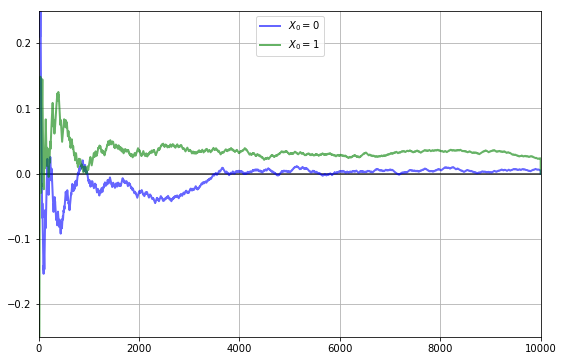

In [102]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.grid()
ax.hlines(0, 0, 10000, lw=2, alpha=0.6)
ax.set_xlim(0,10000)
ax.set_ylim(-0.25,0.25)
ax.plot(deltas_0, 'blue', linewidth=2, label=r'$X_{0} = 0$', alpha=0.6)
ax.plot(deltas_1, 'green', linewidth=2, label=r'$X_{0} = 1$', alpha=0.6)
ax.legend(loc='upper center')
plt.show()

# Text Solution to Exercise 1

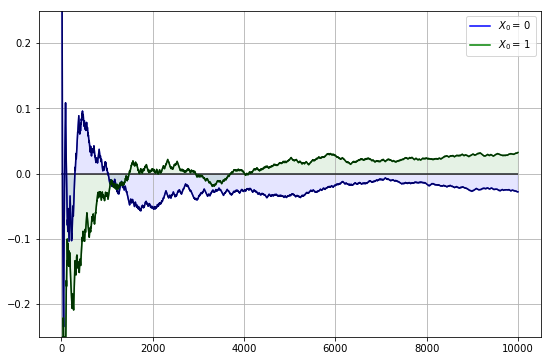

In [98]:
alpha = beta = 0.1
N = 10000
p = beta / (alpha + beta)

P = ((1 - alpha, alpha),   # Careful: P and p are distinct
     (beta, 1 - beta))
P = np.array(P)
mc = qe.MarkovChain(P)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-0.25, 0.25)
ax.grid()
ax.hlines(0, 0, N, lw=2, alpha=0.6)  # Horizonal line at zero

for x0, col in ((0, 'blue'), (1, 'green')):
    # == Generate time series for worker that starts at x0 == #
    X = mc.simulate(N, init=x0)
    # == Compute fraction of time spent unemployed, for each n == #
    X_bar = (X == 0).cumsum() / (1 + np.arange(N, dtype=float))
    # == Plot == #
    ax.fill_between(range(N), np.zeros(N), X_bar - p, color=col, alpha=0.1)
    ax.plot(X_bar - p, color=col, label=r'$X_0 = \, {} $'.format(x0))
    ax.plot(X_bar - p, 'k-', alpha=0.6)  # Overlay in black--make lines clearer

ax.legend(loc='upper right')
plt.show()

# My Solution to Exercise 2

In [263]:
import re
import string
import pandas as pd

txt = 'web_graph_data.txt'
with open('data/%s' % txt, encoding='utf-8', mode='r') as f:
    data = f.read()
data = data.strip('\s')
data = data.replace('\n', '')

In [264]:
letters = list(string.ascii_lowercase)
nodes = letters[letters.index('a'):letters.index('n')+1]
P = np.zeros((len(nodes),len(nodes)))
outbound = {}
inbound = {}
rank = {}

for node in nodes:
    outbound[node] = re.findall('%s\s->\s\w' % node, data)
    inbound[node] = re.findall('\w\s->\s%s' % node, data)
    k = len(outbound[node])
    for out in outbound[node]:
        index = (nodes.index(node), nodes.index(out[-1]))
        P[index] = 1/k

mc = qe.MarkovChain(P)

In [265]:
for node, r in zip(nodes,mc.stationary_distributions[0]):
    rank[node] = r

In [266]:
rank = pd.DataFrame(data = rank, index=[0]).T

In [275]:
rank.columns = ['rank']
rank.sort_values('rank', ascending=False)

,rank
g,0.160708
j,0.159362
m,0.119515
n,0.108770
k,0.091063
b,0.083265
e,0.053121
i,0.053121
c,0.048342
h,0.045601


# Text Solution to Exercise 2

In [276]:
%%file web_graph_data.txt
a -> d;
a -> f;
b -> j;
b -> k;
b -> m;
c -> c;
c -> g;
c -> j;
c -> m;
d -> f;
d -> h;
d -> k;
e -> d;
e -> h;
e -> l;
f -> a;
f -> b;
f -> j;
f -> l;
g -> b;
g -> j;
h -> d;
h -> g;
h -> l;
h -> m;
i -> g;
i -> h;
i -> n;
j -> e;
j -> i;
j -> k;
k -> n;
l -> m;
m -> g;
n -> c;
n -> j;
n -> m;

Writing web_graph_data.txt


In [278]:
"""
Return list of pages, ordered by rank
"""
import numpy as np
from operator import itemgetter
import re
from quantecon import MarkovChain

infile = 'web_graph_data.txt'
alphabet = 'abcdefghijklmnopqrstuvwxyz'

n = 14 # Total number of web pages (nodes)

# == Create a matrix Q indicating existence of links == #
#  * Q[i, j] = 1 if there is a link from i to j
#  * Q[i, j] = 0 otherwise
Q = np.zeros((n, n), dtype=int)
f = open(infile, 'r')
edges = f.readlines()
f.close()
for edge in edges:
    from_node, to_node = re.findall('\w', edge)
    i, j = alphabet.index(from_node), alphabet.index(to_node)
    Q[i, j] = 1
# == Create the corresponding Markov matrix P == #
P = np.empty((n, n))
for i in range(n):
    P[i,:] = Q[i,:] / Q[i,:].sum()
mc = MarkovChain(P
                )
# == Compute the stationary distribution r == #
r = mc.stationary_distributions[0]
ranked_pages = {alphabet[i] : r[i] for i in range(n)}
# == Print solution, sorted from highest to lowest rank == #
print('Rankings\n ***')
for name, rank in sorted(ranked_pages.items(), key=itemgetter(1), reverse=1):
    print('{0}: {1:.4}'.format(name, rank))


Rankings
 ***
g: 0.1607
j: 0.1594
m: 0.1195
n: 0.1088
k: 0.09106
b: 0.08326
e: 0.05312
i: 0.05312
c: 0.04834
h: 0.0456
l: 0.03202
d: 0.03056
f: 0.01164
a: 0.002911


# My Solution to Exercise 3

In [317]:
import re
import string
import pandas as pd
import numpy as np
import quantecon as qe
from scipy.stats import norm
from math import erfc, sqrt

def approx_markov(rho, sigma_u, m=3, n=7):
    # Allocate memory for state space and stochastic matrix
    S = np.empty(n)
    P = np.empty((n,n))
    
    # Compute the variance of y
    sigma_y = sqrt((sigma_u**2) / (1 - rho**2))
    
    # Set the entries of the state space
    S[0] = -m*sigma_y
    S[n-1] = m*sigma_y
    s = (S[n-1]-S[0])/(n-1)
    for i in range(n-1):
        S[i+1] = S[i] + s
    
    # Set the entries of the stochastic matrix
    dist = norm(0, sigma_u**2)
    for i in range(n):
        for j in range(n):
            if j == 0:
                P[i,j] = norm.cdf(S[j] - rho*S[i] + s/2)
            elif j == n-1:
                P[i,j] = 1-norm.cdf(S[j] - rho*S[i] - s/2)
            else:
                P[i,j] = norm.cdf(S[j] - rho*S[i] + s/2) - norm.cdf(S[j] - rho*S[i] - s/2)
    
    return qe.MarkovChain(P)

In [318]:
approx_markov(.2, 1)

Markov chain with transition matrix 
P = 
[[ 0.02623975  0.15292348  0.36148306  0.32856758  0.11474175  0.01526608
   0.00077829]
 [ 0.01604437  0.11474175  0.32856758  0.36148306  0.15292348  0.02470056
   0.00153919]
 [ 0.00945177  0.0828345   0.28744516  0.3827893   0.19611376  0.03843696
   0.00292855]
 [ 0.00536222  0.05753099  0.24202381  0.39016596  0.24202381  0.05753099
   0.00536222]
 [ 0.00292855  0.03843696  0.19611376  0.3827893   0.28744516  0.0828345
   0.00945177]
 [ 0.00153919  0.02470056  0.15292348  0.36148306  0.32856758  0.11474175
   0.01604437]
 [ 0.00077829  0.01526608  0.11474175  0.32856758  0.36148306  0.15292348
   0.02623975]]

In [ ]:
%timeit qe.tauchen(.2,1)

10000 loops, best of 3: 90.3 µs per loop


In [ ]:
%timeit approx_markov(.2, 1)